In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

In [17]:
from scripts.downloader import fetch_all_polls

In [18]:
all_polls = fetch_all_polls(cleanup=True, refresh=False)

In [19]:
all_polls.date_started.max()

Timestamp('2024-05-23 00:00:00')

In [20]:
display_columns = ['date_started', 'date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead']

In [21]:
all_polls['conservative_reform_gap'] = all_polls['conservative'] - all_polls['reform_uk']

In [22]:
all_polls[all_polls['conservative_reform_gap']<=5] [['date_started', 'date_concluded', 'pollster', 'conservative', 'reform_uk','conservative_reform_gap']]

,date_started,date_concluded,pollster,conservative,reform_uk,conservative_reform_gap
5,2024-05-22,2024-05-23,Techne UK,19.0,14.0,5.0
26,2024-05-07,2024-05-08,YouGov,18.0,13.0,5.0
35,2024-04-30,2024-05-01,YouGov,18.0,15.0,3.0
61,2024-04-10,2024-04-11,YouGov,19.0,15.0,4.0
68,2024-04-04,2024-04-04,PeoplePolling,19.0,14.0,5.0
70,2024-04-02,2024-04-03,YouGov,20.0,16.0,4.0
74,2024-03-26,2024-03-27,YouGov,21.0,16.0,5.0
86,2024-03-19,2024-03-20,YouGov,19.0,15.0,4.0
105,2024-03-07,2024-03-07,PeoplePolling,18.0,13.0,5.0


In [23]:
all_polls[all_polls['conservative']<=19][display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
26,2024-05-07,2024-05-08,YouGov,18.0,48.0,9.0,lab+30.0
35,2024-04-30,2024-05-01,YouGov,18.0,44.0,10.0,lab+26.0
54,2024-04-03,2024-04-15,Ipsos MORI,19.0,44.0,9.0,lab+25.0
61,2024-04-10,2024-04-11,YouGov,19.0,45.0,8.0,lab+26.0
68,2024-04-04,2024-04-04,PeoplePolling,19.0,45.0,9.0,lab+26.0
86,2024-03-19,2024-03-20,YouGov,19.0,44.0,9.0,lab+25.0
105,2024-03-07,2024-03-07,PeoplePolling,18.0,46.0,10.0,lab+28.0
225,2023-11-14,2023-11-14,PeoplePolling,19.0,49.0,9.0,lab+30.0
226,2023-11-13,2023-11-14,Find Out Now,19.0,46.0,9.0,lab+27.0


In [24]:
all_polls[all_polls.lead_value >23][all_polls.pollster =='Techne UK'][display_columns]

C:\Users\vtxvt\AppData\Local\Temp/ipykernel_38804/1709221033.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_polls[all_polls.lead_value >23][all_polls.pollster =='Techne UK'][display_columns]


,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
25,2024-05-08,2024-05-09,Techne UK,21.0,45.0,11.0,lab+24.0
215,2023-11-22,2023-11-23,Techne UK,21.0,46.0,12.0,lab+25.0
223,2023-11-15,2023-11-16,Techne UK,22.0,46.0,11.0,lab+24.0
646,2022-10-26,2022-10-27,Techne UK,26.0,50.0,10.0,lab+24.0
662,2022-10-19,2022-10-20,Techne UK,22.0,53.0,11.0,lab+31.0
670,2022-10-12,2022-10-13,Techne UK,25.0,49.0,11.0,lab+24.0


In [25]:
all_polls[all_polls['lead_value']> 22]

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,liberal,plaid_cymru,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value,conservative_reform_gap
3,2024-05-23,2024-05-24,We Think,NaN,GB,1242,22.0,47.0,8.0,6.0,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,lab+25.0,25.0,10.0
5,2024-05-22,2024-05-23,Techne UK,NaN,GB,1643,19.0,45.0,12.0,5.0,...,NaN,NaN,2.0,NaN,NaN,NaN,3.0,lab+26.0,26.0,5.0
7,2024-05-21,2024-05-22,YouGov,The Times,GB,2093,21.0,46.0,9.0,7.0,...,NaN,0.0,3.0,NaN,NaN,NaN,1.0,lab+25.0,25.0,9.0
12,2024-05-16,2024-05-17,We Think,NaN,GB,1064,23.0,46.0,8.0,8.0,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,lab+23.0,23.0,12.0
14,2024-05-16,2024-05-16,PeoplePolling,GB News,GB,1476,20.0,46.0,8.0,8.0,...,NaN,0.0,3.0,NaN,NaN,NaN,1.0,lab+26.0,26.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,1982-05-26,1982-05-26,Ipsos MORI,NaN,NaN,NaN,51.0,25.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,con+26.0,26.0,NaN
6195,1981-12-14,1981-12-14,Ipsos MORI,NaN,NaN,NaN,23.0,23.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,all+27.0,27.0,NaN
6234,1980-12-19,1980-12-19,Gallup,The Daily Telegraph,NaN,NaN,32.0,56.0,NaN,NaN,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,lab+24.0,24.0,NaN
6395,1976-11-28,1976-11-28,NOP,NaN,NaN,NaN,55.2,31.3,NaN,NaN,...,9.4,NaN,NaN,NaN,NaN,NaN,NaN,con+23.9,23.9,NaN


In [26]:
all_polls[all_polls.pollster == 'YouGov'].query('lead_value >22')[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
7,2024-05-21,2024-05-22,YouGov,21.0,46.0,9.0,lab+25.0
16,2024-05-15,2024-05-16,YouGov,20.0,47.0,9.0,lab+27.0
26,2024-05-07,2024-05-08,YouGov,18.0,48.0,9.0,lab+30.0
35,2024-04-30,2024-05-01,YouGov,18.0,44.0,10.0,lab+26.0
44,2024-04-23,2024-04-24,YouGov,20.0,45.0,9.0,lab+25.0
53,2024-04-16,2024-04-17,YouGov,21.0,44.0,8.0,lab+23.0
61,2024-04-10,2024-04-11,YouGov,19.0,45.0,8.0,lab+26.0
70,2024-04-02,2024-04-03,YouGov,20.0,43.0,8.0,lab+23.0
86,2024-03-19,2024-03-20,YouGov,19.0,44.0,9.0,lab+25.0
94,2024-03-12,2024-03-13,YouGov,20.0,44.0,9.0,lab+24.0


In [27]:
all_polls[all_polls.pollster == 'Ipsos MORI'].query('conservative < 26')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,liberal,plaid_cymru,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value,conservative_reform_gap
18,2024-05-08,2024-05-14,Ipsos MORI,NaN,GB,1008,20.0,41.0,11.0,11.0,...,NaN,1.0,3.0,NaN,NaN,NaN,4.0,lab+21.0,21.0,11.0
54,2024-04-03,2024-04-15,Ipsos MORI,NaN,GB,1072,19.0,44.0,9.0,9.0,...,NaN,NaN,3.0,NaN,NaN,NaN,6.0,lab+25.0,25.0,6.0
113,2024-02-21,2024-02-28,Ipsos MORI,Evening Standard,GB,1004,20.0,47.0,9.0,8.0,...,NaN,NaN,4.0,NaN,NaN,NaN,2.0,lab+27.0,27.0,12.0
200,2023-12-01,2023-12-07,Ipsos MORI,NaN,GB,1006,24.0,41.0,13.0,9.0,...,NaN,NaN,3.0,NaN,NaN,NaN,3.0,lab+17.0,17.0,17.0
235,2023-11-01,2023-11-08,Ipsos MORI,NaN,GB,1001,25.0,46.0,12.0,6.0,...,NaN,NaN,5.0,NaN,NaN,NaN,5.0,lab+21.0,21.0,21.0
258,2023-10-11,2023-10-18,Ipsos MORI,NaN,GB,1003,24.0,44.0,13.0,8.0,...,NaN,1.0,4.0,NaN,2.0,NaN,NaN,lab+20.0,20.0,20.0
300,2023-09-09,2023-09-12,Ipsos MORI,NaN,GB,1004,24.0,44.0,12.0,8.0,...,NaN,NaN,4.0,NaN,NaN,NaN,3.0,lab+20.0,20.0,20.0
381,2023-06-14,2023-06-20,Ipsos MORI,Evening Standard,GB,1033,25.0,47.0,13.0,8.0,...,NaN,1.0,3.0,NaN,0.0,NaN,1.0,lab+22.0,22.0,22.0
509,2023-02-22,2023-03-01,Ipsos MORI,Evening Standard,UK,1004,25.0,51.0,9.0,5.0,...,NaN,1.0,5.0,NaN,0.0,NaN,0.0,lab+26.0,26.0,22.0
587,2022-12-07,2022-12-13,Ipsos MORI,NaN,GB,1007,23.0,49.0,13.0,3.0,...,NaN,NaN,5.0,NaN,NaN,NaN,4.0,lab+26.0,26.0,21.0


In [28]:
all_polls.loc[(all_polls.lead_value >= 10), 'dd_lead'] = 1
all_polls['dd_lead'] = all_polls['dd_lead'].fillna(0)
all_polls['dd_lead_in_row'] = 0
for ix, value in all_polls['dd_lead'].iteritems():
    if value >= 1:
        polls_before = all_polls.iloc[:ix]['dd_lead']
        polls_after = all_polls.iloc[ix:]['dd_lead']
        next_untrue_poll = polls_after[polls_after == 0].index[0]
        after_polls = next_untrue_poll - ix

        if len(polls_before[polls_before == 0]) == 0:
            before_polls = len(polls_before)
        else:
            last_untrue_poll = polls_before[polls_before == 0].index[-1]
            before_polls = (ix - last_untrue_poll) - 1

        total_polls = before_polls + after_polls
        all_polls.loc[ix, 'dd_lead_in_row'] = total_polls
    else:
        total_polls = 0

In [29]:
all_polls.to_clipboard(sep='\t')

In [30]:
all_polls[all_polls.pollster == 'Gallup']

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,scottish_national_party,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row
4763,2001-06-06,2001-06-06,Gallup,The Daily Telegraph,NaN,2399,30.0,47.0,18.0,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+17.0,17.0,NaN,1.0,45
4773,2001-05-28,2001-05-29,Gallup,The Daily Telegraph,NaN,1462,31.0,47.0,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+16.0,16.0,NaN,1.0,45
4778,2001-05-21,2001-05-23,Gallup,The Daily Telegraph,NaN,1000,32.0,48.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+16.0,16.0,NaN,1.0,45
4782,2001-05-20,2001-05-20,Gallup,BES,NaN,?,25.0,55.0,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+30.0,30.0,NaN,1.0,45
4785,2001-05-14,2001-05-15,Gallup,The Daily Telegraph,NaN,1004,32.0,48.0,13.0,NaN,...,NaN,NaN,NaN,NaN,7.0,lab+16.0,16.0,NaN,1.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6578,1970-12-13,1970-12-13,Gallup,The Daily Telegraph,NaN,NaN,46.0,44.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,con+1.5,1.5,NaN,0.0,0
6579,1970-11-15,1970-11-15,Gallup,The Daily Telegraph,NaN,NaN,43.5,48.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,lab+4.5,4.5,NaN,0.0,0
6580,1970-10-18,1970-10-18,Gallup,The Daily Telegraph,NaN,NaN,46.5,46.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Tie,0.0,NaN,0.0,0
6581,1970-09-13,1970-09-13,Gallup,The Daily Telegraph,NaN,NaN,46.5,44.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,con+2.5,2.5,NaN,0.0,0


In [31]:
all_polls.to_csv('poll_database/poll_database.csv', index=False)
all_polls.to_excel('poll_database/poll_database.xlsx', index=False)
all_polls.to_json('poll_database/poll_database.json', index=False, orient='split')

In [32]:
display_columns = ['date_started', 'date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead']

In [33]:
all_polls['anti_conservative'] = all_polls[
    ['labour', 'liberal_democrat', 'green', 'scottish_national_party', 'plaid_cymru']].fillna(0).sum(axis=1)

In [34]:
all_polls

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,social_democratic_party,united_kingdom_independence_party,reclaim_party,others,lead,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative
0,2024-05-23,2024-05-25,Deltapoll,Mail on Sunday,GB,1517,23.0,45.0,9.0,6.0,...,NaN,NaN,NaN,2.0,lab+22.0,22.0,13.0,1.0,696,63.0
1,2024-05-23,2024-05-24,Opinium,The Observer,GB,1454,27.0,41.0,10.0,7.0,...,NaN,NaN,NaN,1.0,lab+14.0,14.0,17.0,1.0,696,60.0
2,2024-05-23,2024-05-24,YouGov,The Times,GB,2072,22.0,44.0,9.0,6.0,...,NaN,NaN,NaN,1.0,lab+22.0,22.0,8.0,1.0,696,62.0
3,2024-05-23,2024-05-24,We Think,NaN,GB,1242,22.0,47.0,8.0,6.0,...,NaN,NaN,NaN,2.0,lab+25.0,25.0,10.0,1.0,696,64.0
4,2024-05-22,2024-05-23,More in Common,NaN,GB,2008,27.0,44.0,9.0,5.0,...,NaN,NaN,NaN,1.0,lab+17.0,17.0,17.0,1.0,696,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6579,1970-11-15,1970-11-15,Gallup,The Daily Telegraph,NaN,NaN,43.5,48.0,NaN,NaN,...,NaN,NaN,NaN,NaN,lab+4.5,4.5,NaN,0.0,0,48.0
6580,1970-10-18,1970-10-18,Gallup,The Daily Telegraph,NaN,NaN,46.5,46.5,NaN,NaN,...,NaN,NaN,NaN,NaN,Tie,0.0,NaN,0.0,0,46.5
6581,1970-09-13,1970-09-13,Gallup,The Daily Telegraph,NaN,NaN,46.5,44.0,NaN,NaN,...,NaN,NaN,NaN,NaN,con+2.5,2.5,NaN,0.0,0,44.0
6582,1970-08-16,1970-08-16,Gallup,The Daily Telegraph,NaN,NaN,47.0,43.5,NaN,NaN,...,NaN,NaN,NaN,NaN,con+3.5,3.5,NaN,0.0,0,43.5


In [35]:
all_polls.query("green>=11")[display_columns+['green']]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead,green
18,2024-05-08,2024-05-14,Ipsos MORI,20.0,41.0,11.0,lab+21.0,11.0
484,2023-03-16,2023-03-17,PeoplePolling,20.0,45.0,9.0,lab+25.0,13.0
987,2021-10-29,2021-11-04,Ipsos MORI,35.0,36.0,9.0,lab+1.0,11.0
1542,2019-05-28,2019-05-30,Opinium,17.0,22.0,16.0,bre+4.0,11.0
2300,2015-01-16,2015-01-18,Lord Ashcroft Polls,29.0,28.0,9.0,con+1.0,11.0


In [36]:
all_polls.query("green<3")[display_columns+['green']]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead,green
6,2024-05-21,2024-05-22,Survation,27.0,48.0,8.0,lab+21.0,2.0
186,2023-12-15,2023-12-18,Survation,28.0,45.0,10.0,lab+17.0,2.0
262,2023-10-13,2023-10-15,Savanta,29.0,45.0,10.0,lab+16.0,2.0
479,2023-03-17,2023-03-20,Survation,31.0,46.0,8.0,lab+15.0,2.0
489,2023-03-13,2023-03-15,Survation,32.0,48.0,8.0,lab+16.0,2.0
...,...,...,...,...,...,...,...,...
4049,2010-06-10,2010-06-11,YouGov,40.0,32.0,18.0,con+8.0,1.0
4053,2010-05-21,2010-05-23,ICM Research,39.0,32.0,21.0,con+7.0,1.0
4054,2010-05-20,2010-05-21,YouGov,39.0,32.0,21.0,con+7.0,1.0
4057,2010-05-12,2010-05-13,ICM Research,38.0,33.0,21.0,con+5.0,2.0


In [37]:
all_polls.query('client == "Sam Freedman"')[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
560,2023-01-17,2023-01-18,FocalData,24.0,49.0,9.0,lab+25.0


In [38]:
all_polls.query('date_concluded <= "2010-05-06" and date_concluded >= "2005-05-05" and lead_value >= 25')[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
4401,2008-09-12,2008-09-14,Ipsos MORI,52.0,24.0,NaN,con+28.0
4436,2008-05-07,2008-05-08,YouGov,49.0,23.0,17.0,con+26.0


In [39]:
all_polls.query('date_concluded <= "2010-05-06" and date_concluded >= "2005-05-05" and labour <= 20')[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
4314,2009-06-10,2009-06-17,Harris Interactive,35.0,20.0,16.0,con+15.0
4322,2009-05-29,2009-05-31,Ipsos MORI,40.0,18.0,18.0,con+22.0


In [40]:
all_polls.query('date_concluded <= "2010-05-06" and date_concluded >= "2005-05-05" and liberal_democrat >= 32')[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
4105,2010-04-19,2010-04-20,YouGov,31.0,26.0,34.0,lib+3.0
4106,2010-04-19,2010-04-20,Angus Reid Strategies,32.0,23.0,33.0,lib+1.0
4108,2010-04-18,2010-04-20,Ipsos MORI,32.0,28.0,32.0,Tie
4111,2010-04-16,2010-04-19,Angus Reid Strategies,32.0,24.0,32.0,Tie
4116,2010-04-17,2010-04-18,YouGov,32.0,26.0,33.0,lib+1.0


In [41]:
all_polls.query("liberal_democrat + 4 > conservative")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
660,2022-10-20,2022-10-20,PeoplePolling,14.0,53.0,11.0,lab+39.0
1520,2019-07-23,2019-07-24,YouGov,25.0,19.0,23.0,con+2.0
1530,2019-06-24,2019-06-25,YouGov,22.0,20.0,19.0,Tie
1534,2019-06-18,2019-06-19,YouGov,20.0,20.0,21.0,bre+2.0
1535,2019-06-13,2019-06-14,YouGov,21.0,21.0,19.0,bre+3.0
1536,2019-06-09,2019-06-10,YouGov,17.0,19.0,22.0,bre+4.0
1539,2019-06-05,2019-06-06,YouGov,18.0,20.0,20.0,bre+6.0
1540,2019-06-04,2019-06-05,YouGov,18.0,19.0,22.0,bre+3.0
1541,2019-05-31,2019-06-01,YouGov,18.0,19.0,23.0,Tie
1542,2019-05-28,2019-05-30,Opinium,17.0,22.0,16.0,bre+4.0


In [42]:
all_polls.query("pollster == 'YouGov' and green<brexit_party")[display_columns + ['green', 'reform_uk', 'brexit_party']]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead,green,reform_uk,brexit_party
1234,2020-11-04,2020-11-05,YouGov,35.0,40.0,7.0,lab+5.0,4.0,NaN,6.0
1407,2019-11-25,2019-11-26,YouGov,43.0,32.0,13.0,con+11.0,2.0,NaN,4.0
1418,2019-11-12,2019-11-20,YouGov,43.0,29.0,15.0,con+14.0,3.0,NaN,4.0
1427,2019-11-14,2019-11-15,YouGov,45.0,28.0,15.0,con+17.0,3.0,NaN,4.0
1438,2019-11-07,2019-11-08,YouGov,39.0,26.0,17.0,con+13.0,4.0,NaN,10.0
1443,2019-11-05,2019-11-06,YouGov,36.0,25.0,17.0,con+11.0,5.0,NaN,11.0
1445,2019-11-01,2019-11-04,YouGov,38.0,25.0,16.0,con+13.0,5.0,NaN,11.0
1448,2019-10-30,2019-11-01,YouGov,39.0,27.0,16.0,con+12.0,4.0,NaN,7.0
1453,2019-10-29,2019-10-30,YouGov,36.0,21.0,18.0,con+15.0,6.0,NaN,13.0
1456,2019-10-17,2019-10-28,YouGov,36.0,22.0,19.0,con+14.0,6.0,NaN,12.0


In [43]:
all_polls[(all_polls.anti_conservative.fillna(0)) >= 15][
    ['date_concluded', 'pollster', 'labour', 'liberal_democrat', 'green', 'scottish_national_party', 'plaid_cymru',
     'anti_conservative', 'lead']]

,date_concluded,pollster,labour,liberal_democrat,green,scottish_national_party,plaid_cymru,anti_conservative,lead
0,2024-05-25,Deltapoll,45.0,9.0,6.0,3.0,NaN,63.0,lab+22.0
1,2024-05-24,Opinium,41.0,10.0,7.0,2.0,NaN,60.0,lab+14.0
2,2024-05-24,YouGov,44.0,9.0,6.0,3.0,0.0,62.0,lab+22.0
3,2024-05-24,We Think,47.0,8.0,6.0,3.0,NaN,64.0,lab+25.0
4,2024-05-23,More in Common,44.0,9.0,5.0,3.0,0.0,61.0,lab+17.0
...,...,...,...,...,...,...,...,...,...
6579,1970-11-15,Gallup,48.0,NaN,NaN,NaN,NaN,48.0,lab+4.5
6580,1970-10-18,Gallup,46.5,NaN,NaN,NaN,NaN,46.5,Tie
6581,1970-09-13,Gallup,44.0,NaN,NaN,NaN,NaN,44.0,con+2.5
6582,1970-08-16,Gallup,43.5,NaN,NaN,NaN,NaN,43.5,con+3.5


In [44]:
all_polls.query("labour>conservative and lead_value>=35")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
658,2022-10-20,2022-10-21,YouGov,19.0,56.0,10.0,lab+37.0
660,2022-10-20,2022-10-20,PeoplePolling,14.0,53.0,11.0,lab+39.0
661,2022-10-20,2022-10-20,We Think,22.0,57.0,7.0,lab+35.0
663,2022-10-19,2022-10-19,Redfield & Wilton Strategies,19.0,55.0,12.0,lab+36.0
667,2022-10-16,2022-10-16,Redfield & Wilton Strategies,20.0,56.0,11.0,lab+36.0
4965,1997-11-27,1997-12-03,Gallup,21.0,57.0,17.0,lab+36.0
4969,1997-10-30,1997-11-04,Gallup,23.0,63.0,11.0,lab+40.0
4970,1997-10-24,1997-10-27,Ipsos MORI,24.0,60.0,12.0,lab+36.0
4971,1997-10-06,1997-10-06,ICM Research,23.0,59.0,13.0,lab+36.0
4972,1997-09-25,1997-10-01,Gallup,22.0,60.0,14.0,lab+38.0


In [45]:
all_polls.query("labour>55")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
656,2022-10-21,2022-10-22,We Think,22.0,56.0,10.0,lab+34.0
658,2022-10-20,2022-10-21,YouGov,19.0,56.0,10.0,lab+37.0
661,2022-10-20,2022-10-20,We Think,22.0,57.0,7.0,lab+35.0
667,2022-10-16,2022-10-16,Redfield & Wilton Strategies,20.0,56.0,11.0,lab+36.0
4891,1999-10-22,1999-10-25,Ipsos MORI,28.0,56.0,11.0,lab+28.0
...,...,...,...,...,...,...,...
5202,1994-08-22,1994-08-22,Ipsos MORI,23.0,56.0,18.0,lab+33.0
5204,1994-08-01,1994-08-01,Gallup,23.0,56.5,14.5,lab+33.5
5606,1990-04-07,1990-04-07,ICM Research,32.0,56.0,4.0,lab+24.0
5612,1990-03-22,1990-03-22,Harris Interactive,29.0,57.0,6.0,lab+28.0


In [46]:
all_polls.query("pollster=='Ipsos MORI' and labour>conservative and lead_value>=35")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
4970,1997-10-24,1997-10-27,Ipsos MORI,24.0,60.0,12.0,lab+36.0
5168,1995-05-22,1995-05-22,Ipsos MORI,22.0,58.0,16.0,lab+36.0
5185,1994-12-19,1994-12-19,Ipsos MORI,22.0,61.0,13.0,lab+39.0


In [47]:
all_polls.query("pollster=='ICM Research'")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1384,2019-12-06,2019-12-09,ICM Research,42.0,36.0,12.0,con+6.0
1398,2019-11-29,2019-12-02,ICM Research,42.0,35.0,13.0,con+7.0
1410,2019-11-22,2019-11-25,ICM Research,41.0,34.0,13.0,con+7.0
1422,2019-11-15,2019-11-18,ICM Research,42.0,32.0,13.0,con+10.0
1435,2019-11-08,2019-11-11,ICM Research,39.0,31.0,15.0,con+8.0
...,...,...,...,...,...,...,...
5695,1989-05-13,1989-05-13,ICM Research,43.0,43.0,8.0,Tie
5701,1989-04-08,1989-04-08,ICM Research,44.0,40.0,7.0,con+4.0
5708,1989-03-13,1989-03-13,ICM Research,41.0,39.0,8.0,con+2.0
5718,1989-02-11,1989-02-11,ICM Research,42.0,39.0,7.0,con+3.0


In [48]:
all_polls.query("pollster=='Savanta ComRes' and lead_value >= 20")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead


In [49]:
all_polls.query("labour>53")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
651,2022-10-25,2022-10-26,Redfield & Wilton Strategies,23.0,55.0,9.0,lab+32.0
653,2022-10-23,2022-10-23,Redfield & Wilton Strategies,21.0,54.0,11.0,lab+33.0
656,2022-10-21,2022-10-22,We Think,22.0,56.0,10.0,lab+34.0
658,2022-10-20,2022-10-21,YouGov,19.0,56.0,10.0,lab+37.0
661,2022-10-20,2022-10-20,We Think,22.0,57.0,7.0,lab+35.0
...,...,...,...,...,...,...,...
5613,1990-03-20,1990-03-20,Ipsos MORI,31.0,54.0,6.0,lab+23.0
6234,1980-12-19,1980-12-19,Gallup,32.0,56.0,NaN,lab+24.0
6568,1971-09-20,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
6570,1971-07-12,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5


In [50]:
all_polls.query("conservative<29 and labour>conservative and lead_value>14")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2024-05-23,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0
2,2024-05-23,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0
3,2024-05-23,2024-05-24,We Think,22.0,47.0,8.0,lab+25.0
4,2024-05-22,2024-05-23,More in Common,27.0,44.0,9.0,lab+17.0
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
...,...,...,...,...,...,...,...
5266,1993-05-31,1993-05-31,Gallup,25.0,49.0,23.0,lab+24.0
5267,1993-05-24,1993-05-24,Ipsos MORI,28.0,44.0,24.0,lab+16.0
5608,1990-04-02,1990-04-02,Gallup,28.0,52.5,7.5,lab+24.5
5611,1990-03-23,1990-03-23,ICM Research,28.0,55.0,7.0,lab+27.0


In [51]:
all_polls.loc[(all_polls.labour >= 50), 'maj_lead'] = 1
all_polls['maj_lead'] = all_polls['maj_lead'].fillna(0)
all_polls['maj_lead_in_row'] = 0
for ix, value in all_polls['maj_lead'].iteritems():
    if value >= 1:
        polls_before = all_polls.iloc[:ix]['maj_lead']
        polls_after = all_polls.iloc[ix:]['maj_lead']
        next_untrue_poll = polls_after[polls_after == 0].index[0]
        after_polls = next_untrue_poll - ix

        if len(polls_before[polls_before == 0]) == 0:
            before_polls = len(polls_before)
        else:
            last_untrue_poll = polls_before[polls_before == 0].index[-1]
            before_polls = (ix - last_untrue_poll) - 1

        total_polls = before_polls + after_polls
        all_polls.loc[ix, 'maj_lead_in_row'] = total_polls
    else:
        total_polls = 0

In [52]:
all_polls[all_polls['maj_lead_in_row'] > 5][
    ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead',
     'maj_lead_in_row']].to_clipboard(sep='\t')

In [53]:
all_polls

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,reclaim_party,others,lead,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row
0,2024-05-23,2024-05-25,Deltapoll,Mail on Sunday,GB,1517,23.0,45.0,9.0,6.0,...,NaN,2.0,lab+22.0,22.0,13.0,1.0,696,63.0,0.0,0
1,2024-05-23,2024-05-24,Opinium,The Observer,GB,1454,27.0,41.0,10.0,7.0,...,NaN,1.0,lab+14.0,14.0,17.0,1.0,696,60.0,0.0,0
2,2024-05-23,2024-05-24,YouGov,The Times,GB,2072,22.0,44.0,9.0,6.0,...,NaN,1.0,lab+22.0,22.0,8.0,1.0,696,62.0,0.0,0
3,2024-05-23,2024-05-24,We Think,NaN,GB,1242,22.0,47.0,8.0,6.0,...,NaN,2.0,lab+25.0,25.0,10.0,1.0,696,64.0,0.0,0
4,2024-05-22,2024-05-23,More in Common,NaN,GB,2008,27.0,44.0,9.0,5.0,...,NaN,1.0,lab+17.0,17.0,17.0,1.0,696,61.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6579,1970-11-15,1970-11-15,Gallup,The Daily Telegraph,NaN,NaN,43.5,48.0,NaN,NaN,...,NaN,NaN,lab+4.5,4.5,NaN,0.0,0,48.0,0.0,0
6580,1970-10-18,1970-10-18,Gallup,The Daily Telegraph,NaN,NaN,46.5,46.5,NaN,NaN,...,NaN,NaN,Tie,0.0,NaN,0.0,0,46.5,0.0,0
6581,1970-09-13,1970-09-13,Gallup,The Daily Telegraph,NaN,NaN,46.5,44.0,NaN,NaN,...,NaN,NaN,con+2.5,2.5,NaN,0.0,0,44.0,0.0,0
6582,1970-08-16,1970-08-16,Gallup,The Daily Telegraph,NaN,NaN,47.0,43.5,NaN,NaN,...,NaN,NaN,con+3.5,3.5,NaN,0.0,0,43.5,0.0,0


In [54]:
all_polls.loc[(all_polls.labour > all_polls.conservative) & (all_polls.lead_value >= 10), 'dd_lead'] = 1
all_polls['dd_lead'] = all_polls['dd_lead'].fillna(0)

In [55]:
all_polls.loc[(all_polls.lead_value >= 10), 'dd_lead'] = 1
all_polls['dd_lead'] = all_polls['dd_lead'].fillna(0)

In [56]:
all_polls['dd_in_row'] = 0

In [57]:
all_polls.query("pollster=='Savanta ComRes' and labour >42")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead


In [58]:
for ix, value in all_polls['dd_lead'].iteritems():
    if value >= 1:
        polls_before = all_polls.iloc[:ix]['dd_lead']
        polls_after = all_polls.iloc[ix:]['dd_lead']
        next_untrue_poll = polls_after[polls_after == 0].index[0]
        after_polls = next_untrue_poll - ix

        if len(polls_before[polls_before == 0]) == 0:
            before_polls = len(polls_before)
        else:
            last_untrue_poll = polls_before[polls_before == 0].index[-1]
            before_polls = (ix - last_untrue_poll) - 1

        total_polls = before_polls + after_polls
        all_polls.loc[ix, 'dd_in_row'] = total_polls
    else:
        total_polls = 0



In [59]:
all_polls[all_polls['dd_in_row'] > 22][
    ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead', 'dd_in_row']]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead,dd_in_row
0,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0,696
1,2024-05-24,Opinium,27.0,41.0,10.0,lab+14.0,696
2,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0,696
3,2024-05-24,We Think,22.0,47.0,8.0,lab+25.0,696
4,2024-05-23,More in Common,27.0,44.0,9.0,lab+17.0,696
...,...,...,...,...,...,...,...
6124,1983-05-23,Audience Selection,48.0,33.0,NaN,con+15.0,44
6125,1983-05-23,Ipsos MORI,45.0,32.0,NaN,con+13.0,44
6126,1983-05-23,NOP,51.0,33.0,NaN,con+18.0,44
6127,1983-05-23,Harris Interactive,52.0,33.0,NaN,con+19.0,44


In [60]:
polls_after

6575    1.0
6576    0.0
6577    0.0
6578    0.0
6579    0.0
6580    0.0
6581    0.0
6582    0.0
6583    0.0
Name: dd_lead, dtype: float64

In [61]:
before_polls

0

In [62]:
polls_after



6575    1.0
6576    0.0
6577    0.0
6578    0.0
6579    0.0
6580    0.0
6581    0.0
6582    0.0
6583    0.0
Name: dd_lead, dtype: float64

In [63]:
polls_before[polls_before == 0]

696     0.0
701     0.0
702     0.0
703     0.0
707     0.0
       ... 
6565    0.0
6566    0.0
6569    0.0
6573    0.0
6574    0.0
Name: dd_lead, Length: 4100, dtype: float64

In [64]:
all_polls.query("pollster=='Savanta ComRes' and labour>conservative and lead_value>=14")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead


In [65]:
all_polls.query("lead_value >= 15 and labour>conservative")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2024-05-23,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0
2,2024-05-23,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0
3,2024-05-23,2024-05-24,We Think,22.0,47.0,8.0,lab+25.0
4,2024-05-22,2024-05-23,More in Common,27.0,44.0,9.0,lab+17.0
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
...,...,...,...,...,...,...,...
6491,1974-04-16,1974-04-16,Gallup,33.0,49.0,NaN,lab+16.0
6540,1973-05-06,1973-05-06,NOP,31.9,50.1,NaN,lab+18.2
6568,1971-09-20,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
6570,1971-07-12,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5


In [66]:
all_polls.query("lead_value >= 18 and labour>conservative")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2024-05-23,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0
2,2024-05-23,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0
3,2024-05-23,2024-05-24,We Think,22.0,47.0,8.0,lab+25.0
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
6,2024-05-21,2024-05-22,Survation,27.0,48.0,8.0,lab+21.0
...,...,...,...,...,...,...,...
6234,1980-12-19,1980-12-19,Gallup,32.0,56.0,NaN,lab+24.0
6540,1973-05-06,1973-05-06,NOP,31.9,50.1,NaN,lab+18.2
6568,1971-09-20,1971-09-20,Gallup,35.0,54.0,NaN,lab+19.0
6570,1971-07-12,1971-07-12,Gallup,33.5,55.0,NaN,lab+21.5


In [67]:
all_polls.query("conservative <29")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2024-05-23,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0
1,2024-05-23,2024-05-24,Opinium,27.0,41.0,10.0,lab+14.0
2,2024-05-23,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0
3,2024-05-23,2024-05-24,We Think,22.0,47.0,8.0,lab+25.0
4,2024-05-22,2024-05-23,More in Common,27.0,44.0,9.0,lab+17.0
...,...,...,...,...,...,...,...
6204,1981-09-28,1981-09-28,Ipsos MORI,28.0,42.0,NaN,lab+14.0
6205,1981-09-18,1981-09-18,Gallup,27.0,38.0,NaN,lab+5.0
6208,1981-08-17,1981-08-17,NOP,28.0,38.5,NaN,lab+6.0
6226,1981-03-23,1981-03-23,Gallup,28.0,38.0,NaN,lab+6.0


In [68]:
all_polls.query("pollster=='YouGov' and liberal_democrat > 54")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead


In [69]:
all_polls.query("pollster=='Ipsos MORI' and liberal_democrat >=15")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
781,2022-06-22,2022-06-29,Ipsos MORI,30.0,41.0,15.0,lab+11.0
1421,2019-11-15,2019-11-19,Ipsos MORI,44.0,28.0,16.0,con+16.0
1455,2019-10-25,2019-10-28,Ipsos MORI,41.0,24.0,20.0,con+17.0
1483,2019-09-13,2019-09-16,Ipsos MORI,33.0,24.0,23.0,con+9.0
1514,2019-07-26,2019-07-30,Ipsos MORI,34.0,24.0,20.0,con+10.0
...,...,...,...,...,...,...,...
5478,1991-05-28,1991-05-28,Ipsos MORI,37.0,43.0,16.0,lab+6.0
5490,1991-04-22,1991-04-22,Ipsos MORI,42.0,40.0,15.0,con+2.0
5496,1991-03-25,1991-03-25,Ipsos MORI,40.0,40.0,16.0,Tie
5498,1991-03-22,1991-03-22,Ipsos MORI,38.0,44.0,15.0,lab+6.0


In [70]:
all_polls.query("pollster=='YouGov' and liberal_democrat >12")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
178,2023-12-12,2024-01-04,YouGov,26.0,39.5,12.5,lab+13.5
749,2022-07-27,2022-07-28,YouGov,34.0,35.0,13.0,lab+1.0
765,2022-07-13,2022-07-14,YouGov,29.0,40.0,13.0,lab+11.0
771,2022-07-06,2022-07-07,YouGov,29.0,40.0,15.0,lab+11.0
780,2022-06-28,2022-06-29,YouGov,33.0,36.0,13.0,lab+3.0
...,...,...,...,...,...,...,...
4719,2003-09-23,2003-09-25,YouGov,32.0,31.0,30.0,con+1.0
4724,2003-07-22,2003-07-24,YouGov,37.0,34.0,22.0,con+3.0
4729,2003-04-22,2003-04-24,YouGov,32.0,40.0,21.0,lab+8.0
4731,2003-03-26,2003-03-27,YouGov,33.0,40.0,20.0,lab+7.0


In [71]:
all_polls.query("labour + green >= 50")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2024-05-23,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0
2,2024-05-23,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0
3,2024-05-23,2024-05-24,We Think,22.0,47.0,8.0,lab+25.0
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
6,2024-05-21,2024-05-22,Survation,27.0,48.0,8.0,lab+21.0
...,...,...,...,...,...,...,...
918,2022-01-20,2022-01-20,We Think,27.0,45.0,8.0,lab+18.0
920,2022-01-17,2022-01-17,Redfield & Wilton Strategies,30.0,43.0,9.0,lab+13.0
980,2021-11-08,2021-11-08,We Think,30.0,42.0,6.0,lab+12.0
3254,2012-11-10,2012-11-13,Ipsos MORI,32.0,46.0,9.0,lab+14.0


In [72]:
all_polls.query("pollster=='Opinium' and labour >= 41")[display_columns]

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1,2024-05-23,2024-05-24,Opinium,27.0,41.0,10.0,lab+14.0
13,2024-05-15,2024-05-17,Opinium,25.0,43.0,9.0,lab+18.0
50,2024-04-17,2024-04-19,Opinium,25.0,41.0,10.0,lab+16.0
66,2024-04-03,2024-04-05,Opinium,25.0,41.0,10.0,lab+16.0
83,2024-03-20,2024-03-22,Opinium,25.0,41.0,10.0,lab+16.0
...,...,...,...,...,...,...,...
3322,2012-08-30,2012-08-31,Opinium,31.0,42.0,8.0,lab+11.0
3360,2012-07-13,2012-07-16,Opinium,32.0,41.0,9.0,lab+9.0
3374,2012-06-26,2012-06-28,Opinium,31.0,42.0,8.0,lab+11.0
3393,2012-06-08,2012-06-11,Opinium,31.0,42.0,9.0,lab+11.0


In [73]:
#all_polls.query("pollster == 'YouGov' and conservative <31")[display_columns]

In [74]:
reporting_date = 'date_started'

In [75]:
most_recent_date = all_polls[reporting_date].max()
one_year_polls = all_polls[
    all_polls[reporting_date] >= (most_recent_date + relativedelta(months=-17)).replace(day=1)].copy()

In [76]:
pollsters_latest = pd.DataFrame()
for pollster in one_year_polls.pollster.unique():
    pollster_data = one_year_polls.query(f'pollster == "{pollster}"')
    latest_poll = pollster_data.iloc[0]
    pollsters_latest = pd.concat([pollsters_latest, latest_poll], axis=0, ignore_index=True)

In [77]:
one_year_polls.groupby('pollster').nth(0).reset_index()

,pollster,date_started,date_concluded,client,area,sample_size,conservative,labour,liberal_democrat,green,...,others,lead,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row
0,BMG Research,2024-04-22,2024-04-23,The i,GB,1500,25.0,41.0,9.0,6.0,...,1.0,lab+16.0,16.0,11.0,1.0,696,59.0,0.0,0,696
1,Deltapoll,2024-05-23,2024-05-25,Mail on Sunday,GB,1517,23.0,45.0,9.0,6.0,...,2.0,lab+22.0,22.0,13.0,1.0,696,63.0,0.0,0,696
2,Find Out Now,2024-01-24,2024-02-12,The Mirror,GB,18151,22.0,42.0,11.0,7.0,...,4.0,lab+20.0,20.0,12.0,1.0,696,64.0,0.0,0,696
3,FocalData,2023-02-10,2023-02-12,NaN,GB,1041,28.0,48.0,9.0,4.0,...,2.0,lab+20.0,20.0,22.0,1.0,696,64.0,0.0,0,696
4,Ipsos MORI,2024-05-08,2024-05-14,NaN,GB,1008,20.0,41.0,11.0,11.0,...,4.0,lab+21.0,21.0,11.0,1.0,696,67.0,0.0,0,696
5,JL Partners,2024-05-02,2024-05-05,The Rest is Politics,GB,2011,26.0,41.0,11.0,5.0,...,2.0,lab+15.0,15.0,13.0,1.0,696,60.0,0.0,0,696
6,Labour Together,2024-04-19,2024-04-29,NaN,GB,9403,22.0,44.0,10.0,6.0,...,2.0,lab+22.0,22.0,9.0,1.0,696,64.0,0.0,0,696
7,Lord Ashcroft Polls,2024-05-09,2024-05-13,NaN,GB,5485,22.0,45.0,8.0,8.0,...,3.0,lab+23.0,23.0,11.0,1.0,696,64.0,0.0,0,696
8,More in Common,2024-05-22,2024-05-23,NaN,GB,2008,27.0,44.0,9.0,5.0,...,1.0,lab+17.0,17.0,17.0,1.0,696,61.0,0.0,0,696
9,Opinium,2024-05-23,2024-05-24,The Observer,GB,1454,27.0,41.0,10.0,7.0,...,1.0,lab+14.0,14.0,17.0,1.0,696,60.0,0.0,0,696


In [78]:
pollsters_latest = one_year_polls.groupby('pollster').nth(1).reset_index()

In [79]:
one_year_polls.query(f'pollster == "Opinium"')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,others,lead,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row
1,2024-05-23,2024-05-24,Opinium,The Observer,GB,1454,27.0,41.0,10.0,7.0,...,1.0,lab+14.0,14.0,17.0,1.0,696,60.0,0.0,0,696
13,2024-05-15,2024-05-17,Opinium,The Observer,GB,1458,25.0,43.0,9.0,7.0,...,2.0,lab+18.0,18.0,15.0,1.0,696,62.0,0.0,0,696
33,2024-05-01,2024-05-03,Opinium,The Observer,GB,1402,24.0,40.0,11.0,7.0,...,2.0,lab+16.0,16.0,12.0,1.0,696,62.0,0.0,0,696
50,2024-04-17,2024-04-19,Opinium,The Observer,GB,1431,25.0,41.0,10.0,7.0,...,1.0,lab+16.0,16.0,12.0,1.0,696,62.0,0.0,0,696
66,2024-04-03,2024-04-05,Opinium,The Observer,GB,1318,25.0,41.0,10.0,8.0,...,1.0,lab+16.0,16.0,14.0,1.0,696,63.0,0.0,0,696
83,2024-03-20,2024-03-22,Opinium,The Observer,UK,1874,25.0,41.0,10.0,8.0,...,2.0,lab+16.0,16.0,14.0,1.0,696,62.0,0.0,0,696
101,2024-03-06,2024-03-08,Opinium,The Observer,UK,2054,25.0,41.0,10.0,7.0,...,4.0,lab+16.0,16.0,14.0,1.0,696,61.0,0.0,0,696
109,2024-02-28,2024-03-01,Opinium,NaN,UK,2050,25.0,40.0,10.0,7.0,...,3.0,lab+15.0,15.0,13.0,1.0,696,60.0,0.0,0,696
118,2024-02-21,2024-02-23,Opinium,The Observer,UK,2079,27.0,42.0,10.0,7.0,...,1.0,lab+15.0,15.0,17.0,1.0,696,62.0,0.0,0,696
126,2024-02-14,2024-02-16,Opinium,The Observer,UK,2002,27.0,43.0,10.0,7.0,...,2.0,lab+16.0,16.0,18.0,1.0,696,63.0,0.0,0,696


In [80]:
pollsters_latest = pd.DataFrame()
for pollster in one_year_polls.pollster.unique():
    pollster_data = one_year_polls.query(f'pollster == "{pollster}"')
    latest_poll = pollster_data.iloc[0]
    pollsters_latest = pollsters_latest.append(latest_poll)

In [81]:
pollsters_latest.sort_values('date_started', ascending=False)

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,others,lead,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row
0,2024-05-23,2024-05-25,Deltapoll,Mail on Sunday,GB,1517,23.0,45.0,9.0,6.0,...,2.0,lab+22.0,22.0,13.0,1.0,696.0,63.0,0.0,0.0,696.0
1,2024-05-23,2024-05-24,Opinium,The Observer,GB,1454,27.0,41.0,10.0,7.0,...,1.0,lab+14.0,14.0,17.0,1.0,696.0,60.0,0.0,0.0,696.0
2,2024-05-23,2024-05-24,YouGov,The Times,GB,2072,22.0,44.0,9.0,6.0,...,1.0,lab+22.0,22.0,8.0,1.0,696.0,62.0,0.0,0.0,696.0
3,2024-05-23,2024-05-24,We Think,NaN,GB,1242,22.0,47.0,8.0,6.0,...,2.0,lab+25.0,25.0,10.0,1.0,696.0,64.0,0.0,0.0,696.0
4,2024-05-22,2024-05-23,More in Common,NaN,GB,2008,27.0,44.0,9.0,5.0,...,1.0,lab+17.0,17.0,17.0,1.0,696.0,61.0,0.0,0.0,696.0
5,2024-05-22,2024-05-23,Techne UK,NaN,GB,1643,19.0,45.0,12.0,5.0,...,3.0,lab+26.0,26.0,5.0,1.0,696.0,64.0,0.0,0.0,696.0
6,2024-05-21,2024-05-22,Survation,NaN,UK,1016,27.0,48.0,8.0,2.0,...,3.0,lab+21.0,21.0,19.0,1.0,696.0,62.0,0.0,0.0,696.0
9,2024-05-19,2024-05-19,Redfield & Wilton Strategies,NaN,GB,3700,23.0,45.0,10.0,5.0,...,1.0,lab+22.0,22.0,11.0,1.0,696.0,62.0,0.0,0.0,696.0
10,2024-05-17,2024-05-19,Savanta,The Telegraph,GB,2295,26.0,43.0,10.0,5.0,...,4.0,lab+17.0,17.0,17.0,1.0,696.0,61.0,0.0,0.0,696.0
14,2024-05-16,2024-05-16,PeoplePolling,GB News,GB,1476,20.0,46.0,8.0,8.0,...,1.0,lab+26.0,26.0,6.0,1.0,696.0,65.0,0.0,0.0,696.0


In [82]:
top_five = {'Ipsos MORI': 100,
            'Opinium': 79,
            'YouGov': 77,
            'Kantar Public': 69,
            'Number Cruncher Politics': 61,
            'Survation': 59,
            'Panelbase': 57,
            'Deltapoll': 46,
            'BMG Research': 44,
            'FocalData': 39,
            'ICM Research': 35,
            'Savanta': 34,
            'Find Out Now': 34*0.3,  # Ludicrous Local Election Polling
            'Redfield & Wilton Strategies': 34*.75,
            'Techne UK': 34*.75,
            'JL Partners Polls': 34*.75,
            'PeoplePolling': 34*.75,
            'Omnisis': 34*.75,
            }

top_two = {'Ipsos MORI': 100,
           'Survation': 85,
           'Kantar Public': 85,
           'Panelbase': 74,
           'Number Cruncher Politics': 71,
           'Opinium': 71,
           'YouGov': 67,
           'Deltapoll': 50,
           'FocalData': 42,
           'BMG Research': 39,
           'Savanta': 29,
           'ICM Research': 27,
           'Find Out Now': 34*0.3,  # Ludicrous Local Election Polling
           'Redfield & Wilton Strategies': 34*.75,
           'Techne UK': 34*.75,
           'JL Partners Polls': 34*.75,
           'PeoplePolling': 34*.75,
           'Omnisis': 34*.75,
           }

In [83]:
(71*3 + 79*2 + 100)/6

78.5

In [84]:
recency_weights = {
    -1: 100,
    5: 100,
    14: 70,
    28: 5,
    90: 0
}


def get_recency_weight(poll_date, current_date, return_category=False):
    days_since_poll = (current_date - poll_date).days
    days_start_of_range = weight_start_of_range = 0
    category = 0
    for day, weight in recency_weights.items():
        category += 1
        if days_since_poll > day:
            days_start_of_range = day
            weight_start_of_range = weight
        else:
            percent_through_range = (days_since_poll - days_start_of_range)/(day - days_start_of_range)
            full_weight = weight_start_of_range - ((weight_start_of_range - weight)*percent_through_range)
            if return_category:
                return category - 2
            else:
                return full_weight
    if return_category:
        return category - 1
    else:
        return 0


In [85]:
def get_pollster_weight(pollster):
    if pollster not in top_two:
        return 0
    top_five_score = top_five[pollster]
    top_two_score = top_two[pollster]
    pollster_w = (3*top_two_score + 2*top_five_score + 100)/6
    return pollster_w


In [86]:
for pollster in top_two.keys():
    print(f' {pollster:30s}: {get_pollster_weight(pollster):.1f}')

 Ipsos MORI                    : 100.0
 Survation                     : 78.8
 Kantar Public                 : 82.2
 Panelbase                     : 72.7
 Number Cruncher Politics      : 72.5
 Opinium                       : 78.5
 YouGov                        : 75.8
 Deltapoll                     : 57.0
 FocalData                     : 50.7
 BMG Research                  : 50.8
 Savanta                       : 42.5
 ICM Research                  : 41.8
 Find Out Now                  : 25.2
 Redfield & Wilton Strategies  : 37.9
 Techne UK                     : 37.9
 JL Partners Polls             : 37.9
 PeoplePolling                 : 37.9
 Omnisis                       : 37.9


In [87]:
from scripts.constants import major_parties

Timestamp('2024-05-26 00:00:00', freq='D')

Text(0.5, 1.0, 'Campaign Polling Average')

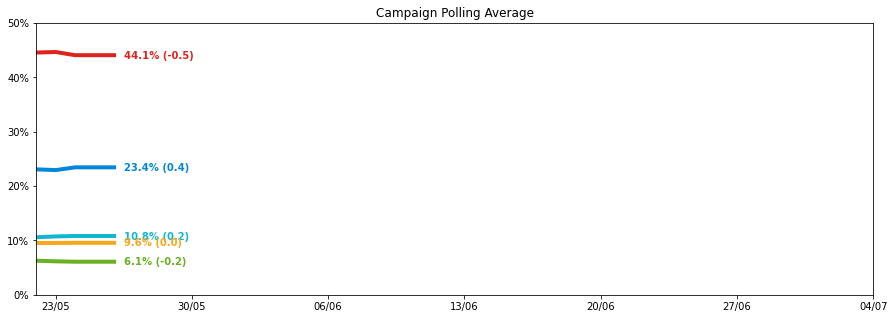

In [247]:
from scripts.constants import party_colors, major_parties
import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()


last_date = averages_per_day[averages_per_day.labour>0].index.max()


for party in parties_to_include:
    plt.plot_date(
        x=averages_per_day.index,
        y=averages_per_day[party],
        fmt='-',
        color=party_colors[party],
        linewidth=4)
    
    end_value = averages_per_day.loc[last_date, party]
    start_value = averages_per_day.iloc[0][party]
    change = end_value - start_value
    
    
    annotation_text = f'{end_value:.1f}% ({change:.1f})'
    annotation_x = last_date + timedelta(hours=12)
    annotation_y = end_value - 1
    ax.annotate(annotation_text, (annotation_x, annotation_y), textcoords="offset points", xytext=(0, 10), ha='left', fontsize=10, va ='top', color=party_colors[party], fontweight='bold')
    
    

ax.set_yticks(arange(0, 51, 10), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator(interval=7)
major_locator = plt.matplotlib.dates.WeekdayLocator(byweekday=plt.matplotlib.dates.TH, interval=1)
major_fmt = plt.matplotlib.dates.DateFormatter('%d/%m')

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

# set xlim
ax.set_xlim([campaign_start, election_date])

plot_title = 'Campaign Polling Average'
plt.title(plot_title)



In [206]:
~averages_per_day

,labour,conservative,reform_uk,liberal_democrat,green,lead
2024-05-22,44.563043,23.078861,10.584476,9.53493,6.272907,21.484182
2024-05-23,44.663558,22.94339,10.740565,9.53804,6.159528,21.720168
2024-05-24,44.076499,23.446219,10.819124,9.563926,6.085867,20.630280
2024-05-25,44.076499,23.446219,10.819124,9.563926,6.085867,20.630280
2024-05-26,44.076499,23.446219,10.819124,9.563926,6.085867,20.630280
2024-05-27,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-28,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,NaN,NaN,NaN,NaN,NaN,NaN


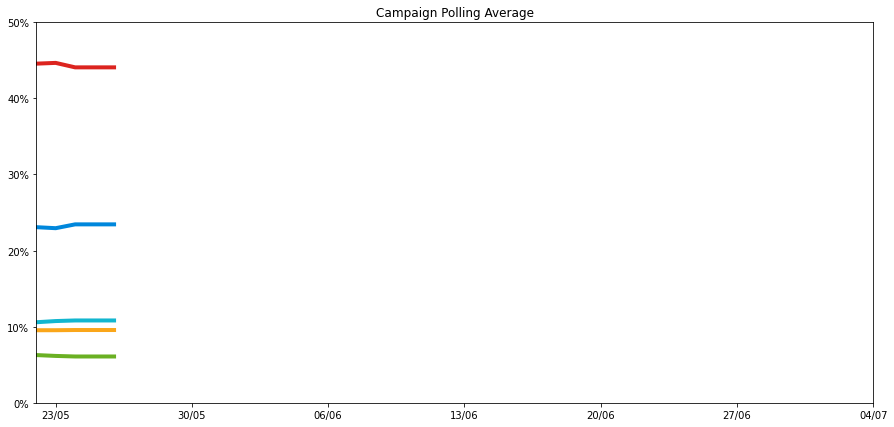

In [219]:
from scripts.constants import party_colors, major_parties
import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 7))
fig.set_facecolor('white')
ax = plt.gca()

for party in parties_to_include:
    plt.plot_date(
        x=averages_per_day.index,
        y=averages_per_day[party],
        fmt='-',
        color=party_colors[party],
        linewidth=4)

ax.set_yticks(arange(0, 51, 10), minor=False)
#major_locator = plt.matplotlib.dates.DayLocator(interval=7)
major_locator = plt.matplotlib.dates.WeekdayLocator(byweekday=plt.matplotlib.dates.TH, interval=1)
major_fmt = plt.matplotlib.dates.DateFormatter('%d/%m')

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

#set xlim
ax.set_xlim([campaign_start, election_date])

plot_title = 'Campaign Polling Average'
plt.title(plot_title)
# source = 'Source: Wikipedia - Opinion polling for the next United Kingdom general election'
# plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')
fig.savefig('html_outputs/campaign_polling.png', bbox_inches='tight', pad_inches=0.2)

2024-05-22    23.078861
2024-05-23    22.943390
2024-05-24    23.446219
2024-05-25    23.446219
2024-05-26    23.446219
2024-05-27    23.446219
Freq: D, dtype: float64

In [147]:
pollsters_latest = pd.DataFrame()
for pollster in one_year_polls.pollster.unique():
    pollster_data = one_year_polls.query(f'pollster == "{pollster}"')
    latest_poll = pollster_data.iloc[0]
    pollsters_latest = pollsters_latest.append(latest_poll)

In [129]:
pollsters_latest['recency_weight'] = pollsters_latest[reporting_date].apply(get_recency_weight,
                                                                            current_date=most_recent_date)
pollsters_latest['pollster_weight'] = pollsters_latest['pollster'].apply(get_pollster_weight)
pollsters_latest['poll_weight'] = pollsters_latest['pollster_weight']*(pollsters_latest['recency_weight']/100)

In [130]:
most_recent_date

Timestamp('2024-05-23 00:00:00')

In [131]:
current_average = pd.DataFrame(columns=major_parties + ['lead'], index=['Polling Average'])
lead_party = ''
max_vote_share = 0
second_vote_share = 0
for party in major_parties:
    party_vote_share = pollsters_latest[party].dot(pollsters_latest['poll_weight'])/pollsters_latest[
        'poll_weight'].sum()
    if party_vote_share > max_vote_share:
        second_vote_share = max_vote_share
        max_vote_share = party_vote_share
        lead_party = party
    else:
        if party_vote_share > second_vote_share:
            second_vote_share = party_vote_share
    current_average.loc['Polling Average', party] = party_vote_share
    #current_average.loc['Polling Average', party] = f'{party_vote_share:.1f}%'
#current_average.loc['Polling Average', 'lead'] = f'{lead_party:.3s}+{max_vote_share - second_vote_share:.1f}%'
current_average.loc['Polling Average', 'lead_value'] = max_vote_share - second_vote_share


In [132]:
current_average

,conservative,labour,liberal_democrat,lead,lead_value
Polling Average,23.446219,44.076499,9.563926,NaN,20.63028


In [91]:
one_year_polls['poll_month'] = one_year_polls[reporting_date].apply(lambda x: x.replace(day=1))

In [92]:
pollster_monthly_summary = one_year_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
monthly_summary = pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [93]:
all_polls.loc[all_polls.date_concluded<all_polls.date_started, 'date_started'] - pd.offsets.DateOffset(years=1)

Series([], Name: date_started, dtype: datetime64[ns])

In [94]:
from scripts.functions import format_lead

monthly_summary[['lead', 'lead_value']] = monthly_summary.apply(format_lead, axis=1, result_type='expand')

In [95]:
monthly_summary.iloc[:0:-1].to_clipboard(sep='\t')

In [96]:
display(pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns])
display(current_average)
display(monthly_summary.iloc[:0:-1])

,date_started,date_concluded,pollster,conservative,labour,liberal_democrat,lead
6,2024-05-21,2024-05-22,Survation,27.0,48.0,8.0,lab+21.0
1,2024-05-23,2024-05-24,Opinium,27.0,41.0,10.0,lab+14.0
2,2024-05-23,2024-05-24,YouGov,22.0,44.0,9.0,lab+22.0
18,2024-05-08,2024-05-14,Ipsos MORI,20.0,41.0,11.0,lab+21.0
0,2024-05-23,2024-05-25,Deltapoll,23.0,45.0,9.0,lab+22.0
10,2024-05-17,2024-05-19,Savanta,26.0,43.0,10.0,lab+17.0
5,2024-05-22,2024-05-23,Techne UK,19.0,45.0,12.0,lab+26.0
9,2024-05-19,2024-05-19,Redfield & Wilton Strategies,23.0,45.0,10.0,lab+22.0
14,2024-05-16,2024-05-16,PeoplePolling,20.0,46.0,8.0,lab+26.0
45,2024-04-22,2024-04-23,BMG Research,25.0,41.0,9.0,lab+16.0


,conservative,labour,liberal_democrat,lead,lead_value
Polling Average,23.446219,44.076499,9.563926,NaN,20.63028


,conservative,labour,liberal_democrat,pollster_count,poll_count,lead,lead_value
poll_month,,,,,,,
2024-05-01,23.297619,43.970238,9.529762,14,35,lab+20.7,20.672619
2024-04-01,23.062222,43.513333,9.267778,15,36,lab+20.5,20.451111
2024-03-01,23.729487,43.483333,9.733333,13,38,lab+19.8,19.753846
2024-02-01,25.133333,43.939394,9.416667,11,35,lab+18.8,18.806061
2024-01-01,25.032222,44.220000,9.697778,15,35,lab+19.2,19.187778
2023-12-01,25.598485,42.753788,11.147727,11,25,lab+17.2,17.155303
2023-11-01,24.783333,44.680556,10.683333,12,36,lab+19.9,19.897222
2023-10-01,26.514286,44.890476,10.588095,14,38,lab+18.4,18.376190
2023-09-01,26.725000,44.375000,11.175000,10,30,lab+17.6,17.650000


In [97]:
from html2image import Html2Image

hti = Html2Image()

In [98]:



def result_to_opacity(result, range_min, range_max):
    result_range = range_max - range_min
    result_percent = (result - range_min)/result_range
    result_256 = int(result_percent*255)
    return f'{result_256:02x}'


def add_background_colour_to_cells(df, lead_only=False):
    from scripts.constants import party_colors, major_parties
    background_df = df.copy()
    max_party_lead = background_df['lead_value'].max()

    for party in major_parties:
        color = party_colors[party]
        party_max = background_df[party].max()
        party_min = background_df[party].min() - 0.5
        if not lead_only:
            background_df[party] = background_df[party].apply(
                lambda x: f'background-color: {color}{result_to_opacity(x, party_min, party_max)}'
            )
        else:
            background_df[party] = ''
        party_in_lead_mask = df[party] == df[major_parties].max(axis=1)
        background_df.loc[party_in_lead_mask, 'lead_value'] = df['lead_value'].apply(
            lambda x: f'background-color: {color}{result_to_opacity(x, 0, max_party_lead)}'
        )

    if reporting_date in background_df.columns:
        background_df[reporting_date] = background_df[reporting_date].apply(get_recency_weight,
                                                                            current_date=most_recent_date)
        background_df[reporting_date] = background_df[reporting_date].apply(
            lambda x: f'background-color: #A9D08E{result_to_opacity(x, 0, 100)}'
        )

    for column in background_df.columns:
        if not (column in major_parties or column in ['lead_value', reporting_date]):
            background_df[column] = ''
    return background_df

In [99]:
def polls_to_html(dataframe, title, highlight_party_columns=True, precision=0):
    dataframe.index.name = 'id'
    table_id = '_'.join(title.split(' ')).lower()

    from pandas.io.formats.style import Styler
    #styler = dataframe.style
    styler = Styler(dataframe, uuid=table_id, cell_ids=True)

    styler.apply(add_background_colour_to_cells, axis=None,
                 lead_only=not (highlight_party_columns))

    styler.format({
        "pollster": lambda x: f"{x}",
        "pollster_count": lambda x: f"{x}",
        "poll_count": lambda x: f"{x}",
        "conservative": lambda x: f"{x:.{precision}f}%",
        "labour": lambda x: f"{x:.{precision}f}%",
        "liberal_democrat": lambda x: f"{x:.{precision}f}%",
        "lead_value": lambda x: f"{x:.{precision}f}%",
        reporting_date: lambda x: f"{x:%d-%b}",
        'poll_month': lambda x: f"{x:%b-%y}",
        'poll_weight': lambda x: f"{x:.0f}",
    })

    styler.set_table_attributes(f'id="{table_id}"')
    styler.hide_index()

    # classes = pd.DataFrame([['_'.join(x.split(' ')).lower() for x in dataframe.columns]]
    #                        , index=dataframe.index, columns=dataframe.columns)
    #
    # styler.set_td_classes(classes)

    #styler.set_caption(title)
    styler.set_properties(**{'min-width': '10px', 'font-size': '12pt', 'text-align': 'center'})

    caption_format = {'selector': 'caption',
                      'props': [('text-align', 'center'), ('font-size', '20pt'), ('color', 'black'),
                                ('padding-bottom', '15')]}
    all_cells = {'selector': '', 'props': [('margin', '0 auto'), ('width', '100%')]}
    date_col = {'selector': '.col0', 'props': [('text-align', 'left')]}

    styles = [all_cells, date_col, caption_format]

    if 'poll_weight' in dataframe.columns:
        styles.append({'selector': '.col2', 'props': [('color', '#AAA')]})

    df_as_html = styler.set_table_styles(styles).render()

    for col in range(0, len(dataframe.columns)):
        df_as_html = df_as_html.replace(f'col{col}', dataframe.columns[col])

    df_as_html = (df_as_html
                  .replace('>poll_count', '>Polls')
                  .replace('>pollster_count', '>Pollsters')
                  .replace('>conservative', '>Conservatives')
                  .replace('>labour', '>Labour')
                  .replace('>liberal_democrat', '>Lib Dem')
                  .replace('>lead_value', '>Lead')
                  .replace(f'>{reporting_date}', '>Date')
                  .replace('>poll_month', '>Month')
                  .replace('>pollster', '>Pollster')
                  .replace('>poll_weight', '>w')
                  )
    return df_as_html

In [100]:
display_columns = [reporting_date, 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead_value']
top_25_html = polls_to_html(all_polls[display_columns][0:25], title='Last 25 Polls')

In [101]:
display_columns = ['pollster', reporting_date, 'poll_weight', 'conservative', 'labour', 'liberal_democrat',
                   'lead_value']
df = pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns]
pollsters_recent = polls_to_html(df, title='Latest Polls', highlight_party_columns=False)

In [102]:
display_columns = ['poll_month', 'pollster_count', 'poll_count', 'conservative', 'labour', 'liberal_democrat',
                   'lead_value']
df = monthly_summary.reset_index()[display_columns].iloc[:0:-1]
monthly_averages = polls_to_html(df, title='Monthly Poll Average', highlight_party_columns=True, precision=1)

In [103]:
polling_average = polls_to_html(current_average[['conservative', 'labour', 'liberal_democrat', 'lead_value']],
                                title='Polling Average', highlight_party_columns=False, precision=1)

In [104]:

css = "body {background: white;}"
# hti.screenshot(html_str=top_25_html, css_str=css, save_as='tmp.png', size=(800, 650))
# hti.screenshot(html_str=pollsters_recent, css_str=css, save_as='tmp.png', size=(700, 400))

In [105]:
with open('html_outputs/top_25.html', 'w') as f:
    f.write(top_25_html)
with open('html_outputs/pollsters_recent.html', 'w') as f:
    f.write(pollsters_recent)
with open('html_outputs/monthly_averages.html', 'w') as f:
    f.write(monthly_averages)
with open('html_outputs/polling_average.html', 'w') as f:
    f.write(polling_average)

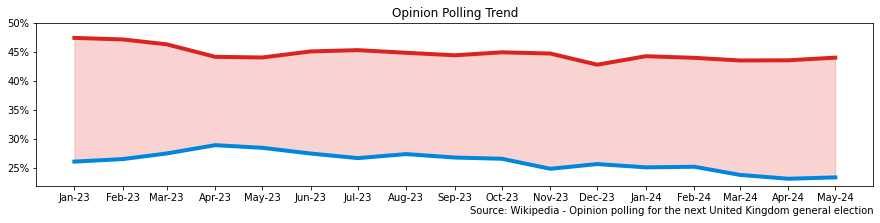

In [106]:
from scripts.constants import party_colors, major_parties
import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 3))
fig.set_facecolor('white')
ax = plt.gca()

# monthly_summary[major_parties[:2]][1:].plot(
#     ax=ax,
#     ylim=[30, 45],
#     color=party_colors,
#     linewidth=3
# )
for party in major_parties[:2]:
    plt.plot_date(
        x=monthly_summary.index[1:],
        y=monthly_summary[party][1:],
        fmt='-',
        color=party_colors[party],
        linewidth=4)

    ax.fill_between(monthly_summary.index[1:], monthly_summary[party][1:],
                    monthly_summary[major_parties[:2]].min(axis=1)[1:], color=party_colors[party], alpha=0.2)
ax.set_yticks(arange(25, 51, 5), minor=False)
major_locator = plt.matplotlib.dates.DayLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

plot_title = 'Opinion Polling Trend'
plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the next United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')
fig.savefig('html_outputs/monthly_trend.png', bbox_inches='tight', pad_inches=0.2)

In [107]:
monthly_summary

,conservative,labour,liberal_democrat,pollster_count,poll_count,lead,lead_value
poll_month,,,,,,,
2022-12-01,26.625000,46.650000,9.350000,10,27,lab+20.0,20.025000
2023-01-01,26.020833,47.383333,9.029167,12,32,lab+21.4,21.362500
2023-02-01,26.461538,47.115385,9.000000,13,35,lab+20.7,20.653846
2023-03-01,27.429167,46.270833,9.012500,12,46,lab+18.8,18.841667
2023-04-01,28.859259,44.109259,10.018519,9,28,lab+15.2,15.250000
2023-05-01,28.404545,43.998485,10.977273,11,32,lab+15.6,15.593939
2023-06-01,27.413636,45.046970,10.890909,11,36,lab+17.6,17.633333
2023-07-01,26.626389,45.266667,11.194444,12,31,lab+18.6,18.640278
2023-08-01,27.319697,44.809091,10.759091,11,27,lab+17.5,17.489394


In [108]:
import datetime

<AxesSubplot:xlabel='date_started'>

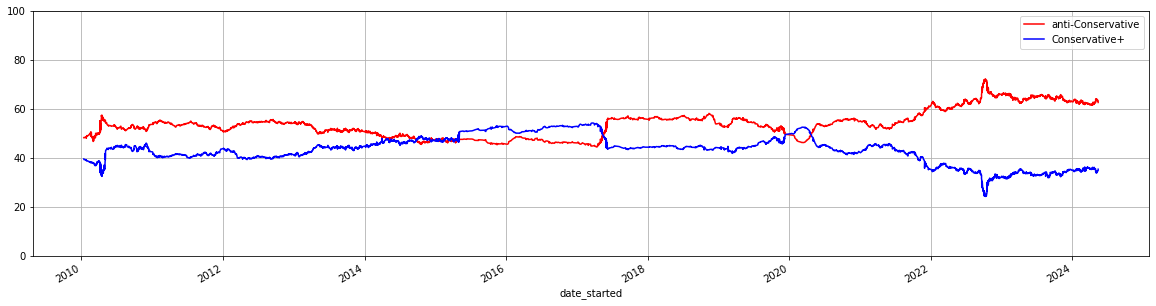

In [109]:
all_polls['anti-Conservative'] = all_polls[
    ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru',
     'scottish_national_party', 'social_democratic_party']].sum(axis=1)
all_polls['Conservative+'] = all_polls[
    ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party', 'reclaim_party']].sum(axis=1)

(all_polls
 .set_index(reporting_date)
 .rolling(window=15).mean()
 .loc[:datetime.date(2010, 1, 13)]
[['anti-Conservative', 'Conservative+']]
 .plot(
    color=['r', 'b']
    , figsize=[20, 5]
    , grid='y'
    , ylim=[0, 100]
)
)

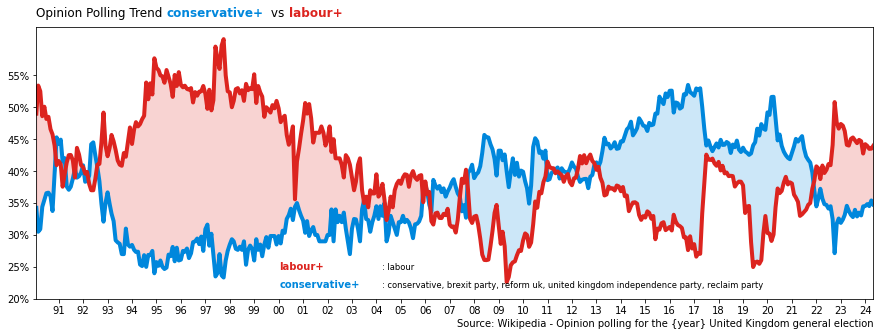

In [110]:
group_colours = {'conservative+': '#0087DC',
                 'labour+': '#DC241F',
                 }
groups = list(group_colours.keys())

# group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party'],
#  'anti-Conservative': ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party'],
#  }

group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party',
                                   'reclaim_party'],
                 'labour+': ['labour'],
                 }

two_group_polls = all_polls[all_polls[reporting_date] >= datetime.datetime(1990, 1, 1)].copy()

for group, parties in group_parties.items():
    two_group_polls[group] = two_group_polls[parties].sum(axis=1)
    two_group_polls.drop(
        columns=parties,
        inplace=True,
    )

two_group_polls['poll_month'] = two_group_polls[reporting_date].apply(lambda x: x.replace(day=1))
two_group_polls = two_group_polls[[reporting_date, 'pollster', 'poll_month'] + groups]

two_group_monthly = two_group_polls.groupby(['poll_month', 'pollster'])[groups].agg(['mean', 'count'])
two_group_monthly.columns = [x if i == 0 else f'count{groups.index(x)}' for x in groups for i in range(0, 2)]
two_group_monthly.drop(columns=[f'count{groups.index(x)}' for x in groups][1:], inplace=True)
two_group_monthly.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in groups}
agg_info['count'] = ['count', 'sum']
two_group_monthly_summary = two_group_monthly.reset_index().groupby(['poll_month']).agg(agg_info)
two_group_monthly_summary.columns = groups + ['pollster_count', 'poll_count']

import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()

for group in groups:
    plt.plot_date(
        x=two_group_monthly_summary.index[1:],
        y=two_group_monthly_summary[group][1:],
        fmt='-',
        color=group_colours[group],
        linewidth=4)

    ax.fill_between(two_group_monthly_summary.index[1:], two_group_monthly_summary[group][1:],
                    two_group_monthly_summary[groups[:2]].min(axis=1)[1:], color=group_colours[group], alpha=0.2)
ax.set_yticks(arange(20, 56, 5), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator([1])
# major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

major_locator = plt.matplotlib.dates.MonthLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter("%y")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.set_xlim([two_group_monthly_summary.index[1], two_group_monthly_summary.index[-1]])

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

titleOffset = 0.125
renderer = fig.canvas.get_renderer()
figwidth = ax.get_window_extent().width/0.8

group_parts = [[f"{group}", group_colours[group], 'bold'] for group in groups]
titleparts = [['Opinion Polling Trend', 'k', 'book']] + [a for b in [[x, [" vs ", 'k', 'regular']] for x in group_parts]
                                                         for a in b][:-1]

for part in titleparts:
    txt = fig.text(titleOffset, 0.9, part[0], ha="left", va="bottom", size="large", color=part[1], weight=part[2])
    titleOffset += (txt.get_window_extent(renderer=renderer).width/figwidth)

# plot_title = 'Opinion Polling Trend'
# plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the {year} United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')

titleOffset = 0.15
for group, parties in group_parties.items():
    colour = group_colours[group]
    fig.text(0.35, titleOffset, group, ha="left", va="bottom", size="medium", color=colour, weight='bold')
    fig.text(0.445, titleOffset, ': ' + ', '.join(parties).replace('_', ' '), ha="left", va="bottom", size="small",
             color='k', weight='regular')
    titleOffset += 0.05
#fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

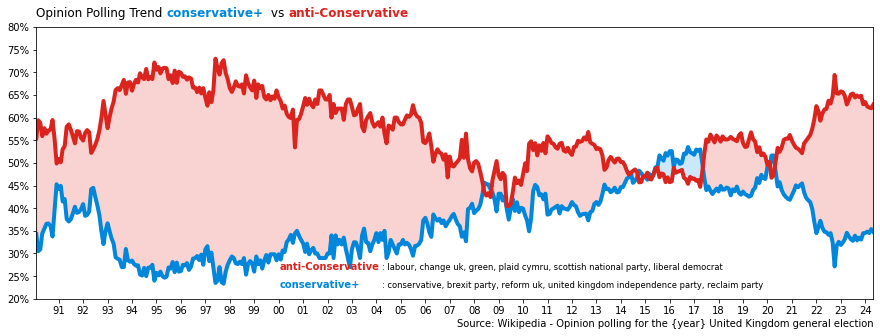

In [111]:
group_colours = {'conservative+': '#0087DC',
                 'anti-Conservative': '#DC241F',
                 }
groups = list(group_colours.keys())

# group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party'],
#  'anti-Conservative': ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party'],
#  }

group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party',
                                   'reclaim_party'],
                 'anti-Conservative': ['labour', 'change_uk', 'green', 'plaid_cymru', 'scottish_national_party',
                                       'liberal_democrat'],
                 }

two_group_polls = all_polls[all_polls[reporting_date] >= datetime.datetime(1990, 1, 1)].copy()

for group, parties in group_parties.items():
    two_group_polls[group] = two_group_polls[parties].sum(axis=1)
    two_group_polls.drop(
        columns=parties,
        inplace=True,
    )

two_group_polls['poll_month'] = two_group_polls[reporting_date].apply(lambda x: x.replace(day=1))
two_group_polls = two_group_polls[[reporting_date, 'pollster', 'poll_month'] + groups]

two_group_monthly = two_group_polls.groupby(['poll_month', 'pollster'])[groups].agg(['mean', 'count'])
two_group_monthly.columns = [x if i == 0 else f'count{groups.index(x)}' for x in groups for i in range(0, 2)]
two_group_monthly.drop(columns=[f'count{groups.index(x)}' for x in groups][1:], inplace=True)
two_group_monthly.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in groups}
agg_info['count'] = ['count', 'sum']
two_group_monthly_summary = two_group_monthly.reset_index().groupby(['poll_month']).agg(agg_info)
two_group_monthly_summary.columns = groups + ['pollster_count', 'poll_count']

import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()

for group in groups:
    plt.plot_date(
        x=two_group_monthly_summary.index[1:],
        y=two_group_monthly_summary[group][1:],
        fmt='-',
        color=group_colours[group],
        linewidth=4)

    ax.fill_between(two_group_monthly_summary.index[1:], two_group_monthly_summary[group][1:],
                    two_group_monthly_summary[groups[:2]].min(axis=1)[1:], color=group_colours[group], alpha=0.2)
ax.set_yticks(arange(20, 81, 5), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator([1])
# major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

major_locator = plt.matplotlib.dates.MonthLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter("%y")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.set_xlim([two_group_monthly_summary.index[1], two_group_monthly_summary.index[-1]])

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

titleOffset = 0.125
renderer = fig.canvas.get_renderer()
figwidth = ax.get_window_extent().width/0.8

group_parts = [[f"{group}", group_colours[group], 'bold'] for group in groups]
titleparts = [['Opinion Polling Trend', 'k', 'book']] + [a for b in [[x, [" vs ", 'k', 'regular']] for x in group_parts]
                                                         for a in b][:-1]

for part in titleparts:
    txt = fig.text(titleOffset, 0.9, part[0], ha="left", va="bottom", size="large", color=part[1], weight=part[2])
    titleOffset += (txt.get_window_extent(renderer=renderer).width/figwidth)

# plot_title = 'Opinion Polling Trend'
# plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the {year} United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')

titleOffset = 0.15
for group, parties in group_parties.items():
    colour = group_colours[group]
    fig.text(0.35, titleOffset, group, ha="left", va="bottom", size="medium", color=colour, weight='bold')
    fig.text(0.445, titleOffset, ': ' + ', '.join(parties).replace('_', ' '), ha="left", va="bottom", size="small",
             color='k', weight='regular')
    titleOffset += 0.05
#fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

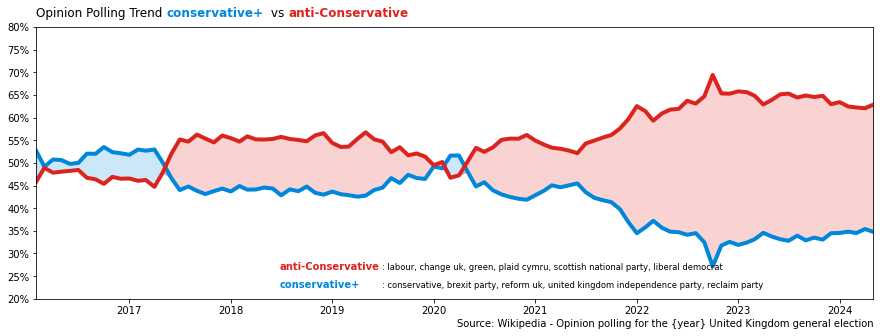

In [112]:
group_colours = {'conservative+': '#0087DC',
                 'anti-Conservative': '#DC241F',
                 }
groups = list(group_colours.keys())

# group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk','united_kingdom_independence_party', 'reclaim_party'],
#  'anti-Conservative': ['labour', 'liberal_democrat', 'alliance', 'change_uk', 'green', 'liberal', 'plaid_cymru', 'scottish_national_party', 'social_democratic_party'],
#  }

group_parties = {'conservative+': ['conservative', 'brexit_party', 'reform_uk', 'united_kingdom_independence_party',
                                   'reclaim_party'],
                 'anti-Conservative': ['labour', 'change_uk', 'green', 'plaid_cymru', 'scottish_national_party',
                                       'liberal_democrat'],
                 }

two_group_polls = all_polls[all_polls[reporting_date] >= datetime.datetime(2016, 1, 1)].copy()

for group, parties in group_parties.items():
    two_group_polls[group] = two_group_polls[parties].sum(axis=1)
    two_group_polls.drop(
        columns=parties,
        inplace=True,
    )

two_group_polls['poll_month'] = two_group_polls[reporting_date].apply(lambda x: x.replace(day=1))
two_group_polls = two_group_polls[[reporting_date, 'pollster', 'poll_month'] + groups]

two_group_monthly = two_group_polls.groupby(['poll_month', 'pollster'])[groups].agg(['mean', 'count'])
two_group_monthly.columns = [x if i == 0 else f'count{groups.index(x)}' for x in groups for i in range(0, 2)]
two_group_monthly.drop(columns=[f'count{groups.index(x)}' for x in groups][1:], inplace=True)
two_group_monthly.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in groups}
agg_info['count'] = ['count', 'sum']
two_group_monthly_summary = two_group_monthly.reset_index().groupby(['poll_month']).agg(agg_info)
two_group_monthly_summary.columns = groups + ['pollster_count', 'poll_count']

import matplotlib.pyplot as plt
from numpy import arange

fig = plt.figure(figsize=(15, 5))
fig.set_facecolor('white')
ax = plt.gca()

for group in groups:
    plt.plot_date(
        x=two_group_monthly_summary.index[1:],
        y=two_group_monthly_summary[group][1:],
        fmt='-',
        color=group_colours[group],
        linewidth=4)

    ax.fill_between(two_group_monthly_summary.index[1:], two_group_monthly_summary[group][1:],
                    two_group_monthly_summary[groups[:2]].min(axis=1)[1:], color=group_colours[group], alpha=0.2)
ax.set_yticks(arange(20, 81, 5), minor=False)
# major_locator = plt.matplotlib.dates.DayLocator([1])
# major_fmt = plt.matplotlib.dates.DateFormatter('%b-%y')

major_locator = plt.matplotlib.dates.MonthLocator([1])
major_fmt = plt.matplotlib.dates.DateFormatter("%Y")

ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_fmt)

ax.set_xlim([two_group_monthly_summary.index[1], two_group_monthly_summary.index[-1]])

ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, p: f'{x/100:.0%}'))

titleOffset = 0.125
renderer = fig.canvas.get_renderer()
figwidth = ax.get_window_extent().width/0.8

group_parts = [[f"{group}", group_colours[group], 'bold'] for group in groups]
titleparts = [['Opinion Polling Trend', 'k', 'book']] + [a for b in [[x, [" vs ", 'k', 'regular']] for x in group_parts]
                                                         for a in b][:-1]

for part in titleparts:
    txt = fig.text(titleOffset, 0.9, part[0], ha="left", va="bottom", size="large", color=part[1], weight=part[2])
    titleOffset += (txt.get_window_extent(renderer=renderer).width/figwidth)

# plot_title = 'Opinion Polling Trend'
# plt.title(plot_title)

source = 'Source: Wikipedia - Opinion polling for the {year} United Kingdom general election'
plt.annotate(source, (1, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', ha='right')

titleOffset = 0.15
for group, parties in group_parties.items():
    colour = group_colours[group]
    fig.text(0.35, titleOffset, group, ha="left", va="bottom", size="medium", color=colour, weight='bold')
    fig.text(0.445, titleOffset, ': ' + ', '.join(parties).replace('_', ' '), ha="left", va="bottom", size="small",
             color='k', weight='regular')
    titleOffset += 0.05
#fig.savefig('html_outputs/monthly_trend.png', bbox_inches = 'tight', pad_inches = 0.2)

In [113]:
one_year_polls['poll_month'] = one_year_polls[reporting_date].apply(lambda x: x.replace(day=1))

In [114]:
kantar_polls = all_polls.query('pollster == "Kantar Public" and date_concluded> "2019-01-01"').copy()
other_polls = all_polls.query('pollster != "Kantar Public" and date_concluded> "2019-01-01"').copy()

In [115]:
kantar_polls['poll_month'] = kantar_polls[reporting_date].apply(lambda x: x.replace(day=1))
other_polls['poll_month'] = other_polls[reporting_date].apply(lambda x: x.replace(day=1))

In [116]:
other_pollster_monthly_summary = other_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
other_pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i
                                          in
                                          range(0, 2)]
other_pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
other_pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
other_monthly_summary = other_pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
other_monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [117]:
kantar_pollster_monthly_summary = kantar_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
kantar_pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for
                                           i in
                                           range(0, 2)]
kantar_pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:],
                                     inplace=True)
kantar_pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
kantar_monthly_summary = kantar_pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
kantar_monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [118]:
other_monthly_summary[['kantar_con', 'kantar_lab']] = kantar_monthly_summary[['conservative', 'labour']]

In [119]:
other_monthly_summary.to_clipboard(sep='\t')

In [120]:
general_elections = all_polls.query('pollster=="General Election"')
general_election_dates = list(general_elections.date_concluded.unique())
#general_elections = general_elections[general_elections.date_concluded > datetime.datetime(2016,1,1)]

In [121]:
for ge in general_election_dates[::-1]:
    if ge < np.datetime64('2016-01-01'):
        continue

    print(ge)

2017-06-08T00:00:00.000000000
2019-12-12T00:00:00.000000000


In [122]:
general_elections[general_elections.date_concluded == ge]

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row,anti-Conservative,Conservative+
1370,2019-12-12,2019-12-12,General Election,NaN,GB,–,44.7,33.0,11.8,2.8,...,11.7,NaN,1.0,45,52.1,0.0,0,45,52.1,46.9
1371,2019-12-12,2019-12-12,General Election,2019 general election,GB,—,44.7,32.9,11.8,2.8,...,11.8,NaN,1.0,45,51.5,0.0,0,45,51.5,46.8
1372,2019-12-12,2019-12-12,General Election,2019 general election,UK,—,43.6,32.1,11.6,2.7,...,11.5,NaN,1.0,45,50.3,0.0,0,45,50.3,45.6


In [123]:
all_polls.query('liberal_democrat + 10 > conservative')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row,anti-Conservative,Conservative+
5,2024-05-22,2024-05-23,Techne UK,NaN,GB,1643,19.0,45.0,12.0,5.0,...,26.0,5.0,1.0,696,64.0,0.0,0,696,64.0,33.0
17,2024-05-15,2024-05-16,Techne UK,NaN,GB,1641,21.0,44.0,12.0,6.0,...,23.0,9.0,1.0,696,64.0,0.0,0,696,64.0,33.0
18,2024-05-08,2024-05-14,Ipsos MORI,NaN,GB,1008,20.0,41.0,11.0,11.0,...,21.0,11.0,1.0,696,67.0,0.0,0,696,67.0,29.0
21,2024-05-12,2024-05-12,Redfield & Wilton Strategies,NaN,GB,3000,21.0,42.0,12.0,6.0,...,21.0,6.0,1.0,696,63.0,0.0,0,696,63.0,36.0
26,2024-05-07,2024-05-08,YouGov,The Times,GB,2072,18.0,48.0,9.0,7.0,...,30.0,5.0,1.0,696,68.0,0.0,0,696,68.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5264,1993-06-11,1993-06-11,NOP,Independent on Sunday,NaN,NaN,27.0,42.0,26.0,NaN,...,15.0,NaN,1.0,3,68.0,0.0,0,3,68.0,27.0
5265,1993-06-05,1993-06-05,ICM Research,Guardian,NaN,NaN,31.0,38.0,26.0,NaN,...,7.0,NaN,0.0,0,64.0,0.0,0,0,64.0,31.0
5266,1993-05-31,1993-05-31,Gallup,Telegraph,NaN,NaN,25.0,49.0,23.0,NaN,...,24.0,NaN,1.0,2,72.0,0.0,0,2,72.0,25.0
5267,1993-05-24,1993-05-24,Ipsos MORI,Times,NaN,NaN,28.0,44.0,24.0,NaN,...,16.0,NaN,1.0,2,68.0,0.0,0,2,68.0,28.0


In [124]:
all_polls.query('labour>56')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row,anti-Conservative,Conservative+
661,2022-10-20,2022-10-20,We Think,NaN,GB,1382,22.0,57.0,7.0,4.0,...,35.0,19.0,1.0,696,72.0,1.0,17,696,72.0,25.0
4920,1999-01-06,1999-01-12,NOP,Evening Standard,NaN,1600,25.0,57.0,12.0,NaN,...,32.0,NaN,1.0,134,69.0,1.0,7,134,69.0,25.0
4932,1998-09-24,1998-09-30,Gallup,The Daily Telegraph,NaN,1028,23.0,57.0,15.0,NaN,...,34.0,NaN,1.0,134,72.0,1.0,8,134,72.0,23.0
4965,1997-11-27,1997-12-03,Gallup,The Daily Telegraph,NaN,1011,21.0,57.0,17.0,NaN,...,36.0,NaN,1.0,134,74.0,1.0,20,134,74.0,21.0
4969,1997-10-30,1997-11-04,Gallup,The Daily Telegraph,NaN,1021,23.0,63.0,11.0,NaN,...,40.0,NaN,1.0,134,74.0,1.0,20,134,74.0,23.0
4970,1997-10-24,1997-10-27,Ipsos MORI,The Times,NaN,1772,24.0,60.0,12.0,NaN,...,36.0,NaN,1.0,134,72.0,1.0,20,134,72.0,24.0
4971,1997-10-06,1997-10-06,ICM Research,The Guardian,NaN,1211,23.0,59.0,13.0,NaN,...,36.0,NaN,1.0,134,72.0,1.0,20,134,72.0,23.0
4972,1997-09-25,1997-10-01,Gallup,The Daily Telegraph,NaN,1014,22.0,60.0,14.0,NaN,...,38.0,NaN,1.0,134,74.0,1.0,20,134,74.0,22.0
4973,1997-09-26,1997-09-29,Ipsos MORI,The Times,NaN,1916,25.0,59.0,13.0,NaN,...,34.0,NaN,1.0,134,72.0,1.0,20,134,72.0,25.0
4974,1997-09-04,1997-09-08,ICM Research,The Guardian,NaN,1206,24.0,60.0,10.0,NaN,...,36.0,NaN,1.0,134,70.0,1.0,20,134,70.0,24.0


In [125]:
GEs_to_use = [

]

In [126]:
all_polls.query('pollster=="Techne UK"')

,date_started,date_concluded,pollster,client,area,sample_size,conservative,labour,liberal_democrat,green,...,lead_value,conservative_reform_gap,dd_lead,dd_lead_in_row,anti_conservative,maj_lead,maj_lead_in_row,dd_in_row,anti-Conservative,Conservative+
5,2024-05-22,2024-05-23,Techne UK,NaN,GB,1643,19.0,45.0,12.0,5.0,...,26.0,5.0,1.0,696,64.0,0.0,0,696,64.0,33.0
17,2024-05-15,2024-05-16,Techne UK,NaN,GB,1641,21.0,44.0,12.0,6.0,...,23.0,9.0,1.0,696,64.0,0.0,0,696,64.0,33.0
25,2024-05-08,2024-05-09,Techne UK,NaN,GB,1638,21.0,45.0,11.0,6.0,...,24.0,9.0,1.0,696,64.0,0.0,0,696,64.0,33.0
34,2024-05-01,2024-05-02,Techne UK,NaN,GB,1633,22.0,44.0,10.0,6.0,...,22.0,9.0,1.0,696,62.0,0.0,0,696,62.0,35.0
43,2024-04-24,2024-04-25,Techne UK,NaN,GB,1642,23.0,44.0,9.0,6.0,...,21.0,12.0,1.0,696,62.0,0.0,0,696,62.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,2022-02-16,2022-02-17,Techne UK,NaN,UK,1625,34.0,39.0,10.0,6.0,...,5.0,NaN,0.0,0,59.0,0.0,0,0,59.0,34.0
898,2022-02-08,2022-02-09,Techne UK,NaN,UK,1631,33.0,41.0,9.0,6.0,...,8.0,NaN,0.0,0,60.0,0.0,0,0,60.0,33.0
902,2022-02-01,2022-02-02,Techne UK,NaN,UK,1631,32.0,40.0,10.0,6.0,...,8.0,NaN,0.0,0,60.0,0.0,0,0,60.0,32.0
907,2022-01-28,2022-01-28,Techne UK,NaN,UK,—,31.0,38.0,12.0,6.0,...,7.0,29.0,0.0,0,60.0,0.0,0,0,60.0,33.0


In [127]:
break

SyntaxError: 'break' outside loop (Temp/ipykernel_38804/370545404.py, line 1)

In [ ]:
import pandas as pd
import requests
from io import StringIO

url = 'https://www.markpack.org.uk/files/2022/07/PollBase-Q2-2022.xlsx'
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
req = requests.get(url, headers=headers)



In [ ]:
data = StringIO(req.content)

In [ ]:
pollbase = pd.read_excel(req.content, sheet_name=1)

In [ ]:
pollbase

In [ ]:
all_polls['poll_month'] = all_polls['date_concluded'].apply(lambda x: x.replace(day=1))

In [ ]:
pollster_monthly_summary = all_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
monthly_summary = pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [ ]:
monthly_summary.query('conservative<31.5')

In [ ]:
monthly_summary.query('(labour-conservative)>9.3')